In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import xgboost as xgb
import os

In [ ]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json

Kaggle API configured successfully.


In [ ]:
# Download the dataset from the 'house-prices-advanced-regression-techniques' competition

!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 520MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [ ]:
#load gthe data from csv files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#setting 'Id' column as the index
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

print(f"Training Data shape: {train_df.shape}")
print(f"Testing Data shape: {test_df.shape}")

print("Data loaded successfully")
train_df.head()



Training Data shape: (1460, 80)
Testing Data shape: (1459, 79)
Data loaded successfully


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


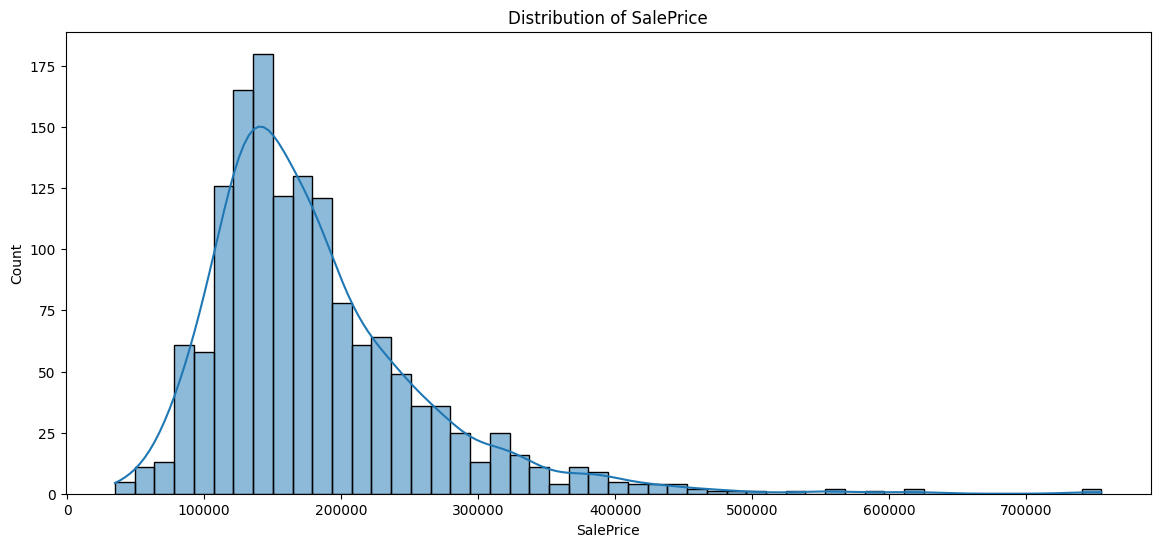

Skewness of SalePrice: 1.8828757597682129


In [ ]:
# Skewness of Saleprice

plt.figure(figsize=(14,6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

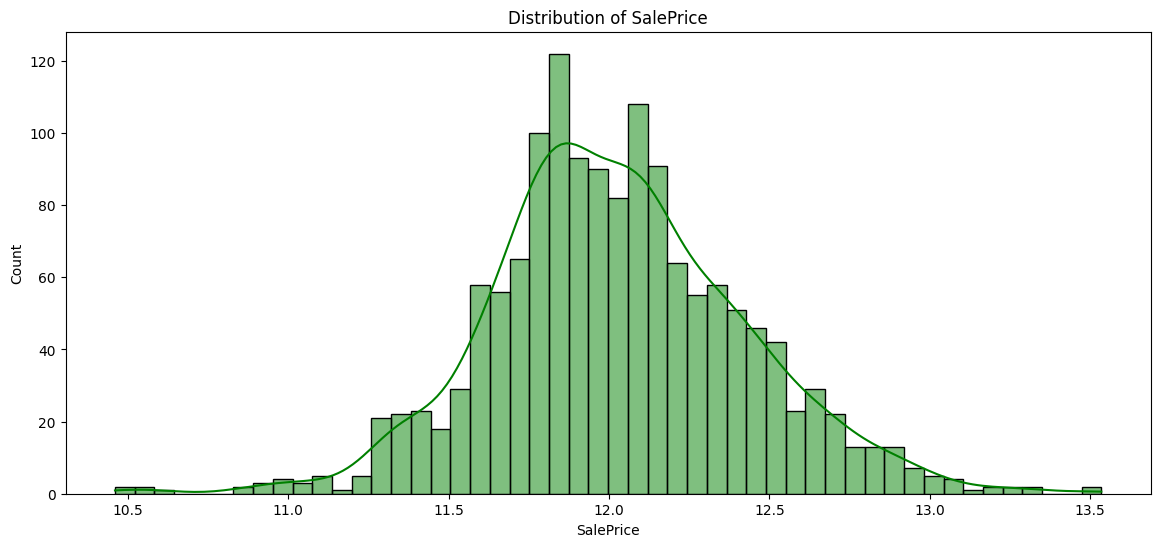

Skewness of log transformed SalePrice: 0.12134661989685333


In [ ]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(14,6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color = 'green')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

print(f"Skewness of log transformed SalePrice: {train_df['SalePrice'].skew()}")

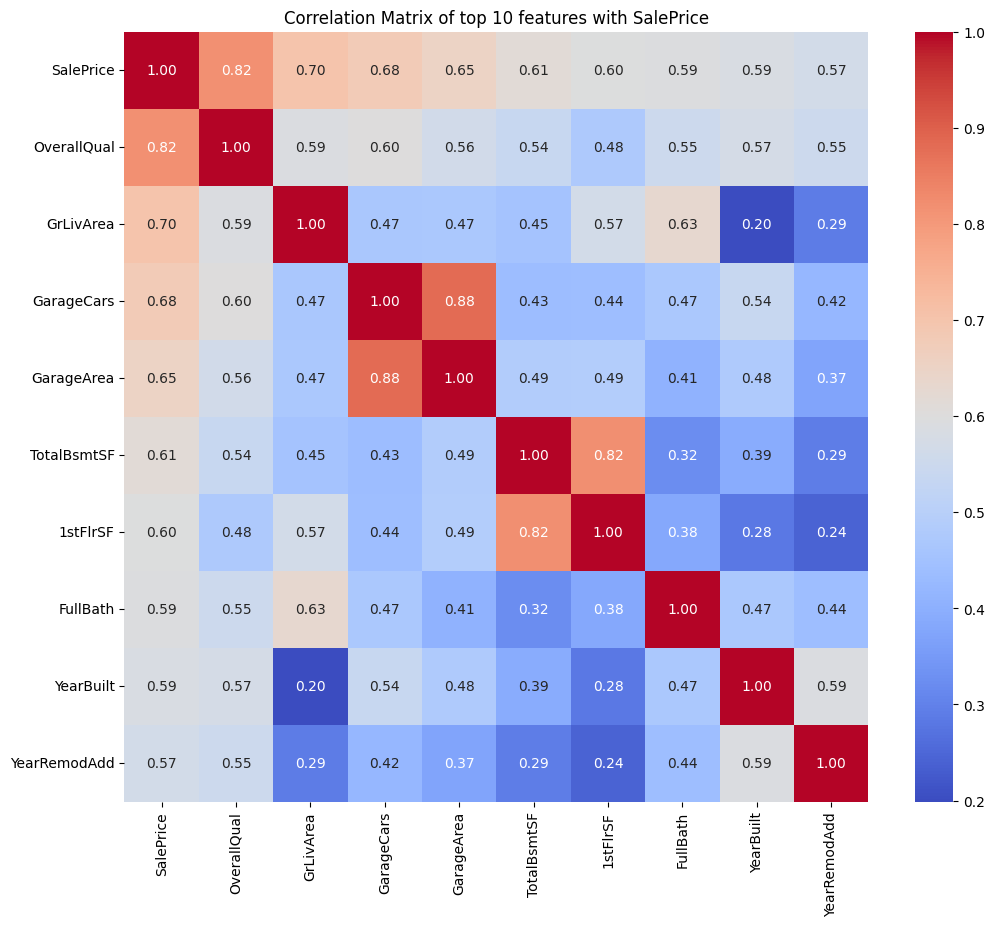

In [ ]:
# find features most correlated with SalePrice
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(top_corr_matrix, annot = True,cmap = 'coolwarm', fmt='.2f')
plt.title('Correlation Matrix of top 10 features with SalePrice')
plt.show()


In [ ]:
# Combine train and test data for preprocessing

combined_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined Data Shape: {combined_data.shape}")

combined_data.head()

Combined Data Shape: (2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
# Find missing values in all_data
missing_data = combined_data.isna().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print("Features with missing values: ")
print(missing_data)

Features with missing values: 
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [ ]:
# Impute numerical columns with 0
numeric_cols_to_impute_zero = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt']
combined_data.isna().sum()
for col in numeric_cols_to_impute_zero:
  if col in combined_data.columns:
    combined_data[col] = combined_data[col].fillna(0)

# check missing values after imputation with 0
combined_data[numeric_cols_to_impute_zero].isna().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0
GarageYrBlt,0


In [ ]:
combined_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,301
70.0,200
80.0,191
50.0,117
65.0,109
...,...
155.0,1
126.0,1
200.0,1


In [ ]:
# Impute LotFrontage with median of neighborhood

if 'LotFrontage' in combined_data.columns and combined_data['LotFrontage'].isna().any():
  combined_data['LotFrontage'] = combined_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Impute catagorical features with "None"
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature','PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
  if col in combined_data.columns:
    combined_data[col] = combined_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
  if col in combined_data.columns:
    combined_data[col] = combined_data[col].fillna(combined_data[col].mode()[0])

print("Missing Values after imputation: ", combined_data.isna().sum().sum())

Missing Values after imputation:  0


In [ ]:
# Feature Engineering

# Create a total square footage feature
combined_data['TotalSF'] = combined_data['TotalBsmtSF'] + combined_data['1stFlrSF'] + combined_data['2ndFlrSF']

# Total Bath feature
combined_data['TotalBath'] = (combined_data['FullBath'] + (0.5 * combined_data['HalfBath']) +
                              combined_data['BsmtFullBath'] + (0.5 * combined_data['BsmtHalfBath']) )

# Age Feature
combined_data['Age'] = combined_data['YrSold'] - combined_data['YearBuilt']

print("New Features created")

New Features created


In [ ]:
combined_data.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [ ]:
categorial_cols = combined_data.select_dtypes(include=['object']).columns
combined_data = pd.get_dummies(combined_data, columns = categorial_cols, drop_first=True)

In [ ]:
combined_data.head()
print(f"Data Shape after encoding: {combined_data.shape}")

Data Shape after encoding: (2919, 262)


In [ ]:
# separate preprocessed data back into training and testing sets
X = combined_data[:len(train_df)]
y = train_df['SalePrice']
X_test_final = combined_data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [ ]:
X_train_scaled

array([[-0.8667643 , -0.01933867, -0.21289571, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 0.07410996, -0.50039047, -0.26524463, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.63154574, -0.15053462, -0.17784146, ..., -0.12510865,
         0.46001984, -0.30263639],
       ...,
       [-0.8667643 , -0.45665849, -0.23409563, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.16110861, -0.6753184 , -0.28337613, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 1.48542135, -0.76278236, -0.65139925, ..., -0.12510865,
         0.46001984, -0.30263639]])

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

In [ ]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# Apply XGBoost on unscaled data since it doesn't require training data to be scaled
xgbr.fit(X_train,y_train)
y_pred_xgb = xgbr.predict(X_val)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
  rmse = np.sqrt(mean_squared_error(y_true,y_pred))
  mae = mean_absolute_error(y_true,y_pred)
  r2 = r2_score(y_true,y_pred)

  print(f" ---- {model_name} Performance -----")
  print(f" RMSE: {rmse:.4f}")
  print(f" MAE: {mae:.4f}")
  print(f" R-Squared: {r2:.4f}")

#Evaluate each model

evaluate_model(y_val, y_pred_xgb, "XGBoost")
print('--'*25)
evaluate_model(y_val, y_pred_lr, "Linear Regression")



 ---- XGBoost Performance -----
 RMSE: 0.1315
 MAE: 0.0858
 R-Squared: 0.9073
--------------------------------------------------
 ---- Linear Regression Performance -----
 RMSE: 0.1734
 MAE: 0.0960
 R-Squared: 0.8389


In [ ]:
# Create a submission file and save to csv file

# using unscaled test data for XBoost Prediction
final_predictions_log = xgbr.predict(X_test_final)

# reverse log transformation to get predictions back to original scale
final_predictions = np.expm1(final_predictions_log)

# Creating submission Dataframe
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

# Saving to csv file

submission.to_csv('submission.csv', index=False)

print("Submission file created sucessfully")
submission.head()


Submission file created sucessfully


,Id,SalePrice
0,1461,125996.656250
1,1462,166337.156250
2,1463,187915.328125
3,1464,197955.718750
4,1465,182225.312500
